In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Stelios
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Stelios
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Loading the data and bringing it to form.
paths={
    'train':'C:/Users/Stelios PC/Desktop/Stelios/Filles/CBS/2nd semester/Natural Language Processing/Final Assignment/liar_dataset/train.tsv',
    'test':'C:/Users/Stelios PC/Desktop/Stelios/Filles/CBS/2nd semester/Natural Language Processing/Final Assignment/liar_dataset/test.tsv',
    'valid':'C:/Users/Stelios PC/Desktop/Stelios/Filles/CBS/2nd semester/Natural Language Processing/Final Assignment/liar_dataset/valid.tsv'}

titles=['ID','label','statement','subject','speaker','job_title','state_info','party_affiliation','barely_true_counts','false_counts','half_true_counts','mostly_true_counts','pants_on_fire_counts','context']

df=pd.DataFrame(columns=titles)
for path in paths.values():
    df_temp=pd.read_csv(path,sep='\t',header=None,names=titles)
    df=pd.concat([df,df_temp],ignore_index=True)

df.drop(columns=['ID'], inplace=True)
df.head()

C:\Users\Stelios PC\AppData\Local\Temp\ipykernel_7152\2673619387.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df=pd.concat([df,df_temp],ignore_index=True)


,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [3]:
# boolean masking, adding 0-1 label for true/false
truth=['true','mostly-true','half-true','barely-true']
df['ft']=df['label'].isin(truth).astype(int)

label_mapping = {
    'pants-fire': 1,
    'false': 2,
    'barely-true': 3,
    'half-true': 4,
    'mostly-true': 5,
    'true': 6}

df['m_label'] = df['label'].replace(label_mapping)

C:\Users\Stelios PC\AppData\Local\Temp\ipykernel_7152\337670209.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['m_label'] = df['label'].replace(label_mapping)


Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12791 entries, 0 to 12790
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   label                 12791 non-null  object 
 1   statement             12791 non-null  object 
 2   subject               12789 non-null  object 
 3   speaker               12789 non-null  object 
 4   job_title             9223 non-null   object 
 5   state_info            10040 non-null  object 
 6   party_affiliation     12789 non-null  object 
 7   barely_true_counts    12789 non-null  float64
 8   false_counts          12789 non-null  float64
 9   half_true_counts      12789 non-null  float64
 10  mostly_true_counts    12789 non-null  float64
 11  pants_on_fire_counts  12789 non-null  float64
 12  context               12660 non-null  object 
 13  ft                    12791 non-null  int32  
 14  m_label               12791 non-null  int64  
dtypes: float64(5), int3

In [5]:
df.describe(include='all')

,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,ft,m_label
count,12791,12791,12789,12789,9223,10040,12789,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000,12660,12791.000000,12791.00000
unique,6,12765,4534,3309,1354,84,24,NaN,NaN,NaN,NaN,NaN,5142,NaN,NaN
top,half-true,On a cap-and-trade plan.,health-care,barack-obama,President,Texas,republican,NaN,NaN,NaN,NaN,NaN,a news release,NaN,NaN
freq,2627,3,474,611,615,1260,5665,NaN,NaN,NaN,NaN,NaN,309,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.583939,13.359059,17.185785,16.497850,6.251388,NaN,0.722148,3.71089
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.978037,24.140086,35.847678,36.165276,16.180777,NaN,0.447957,1.56063
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,1.00000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,2.00000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,3.000000,3.000000,1.000000,NaN,1.000000,4.00000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,15.000000,13.000000,12.000000,5.000000,NaN,1.000000,5.00000


In [6]:
df.isnull().sum()

label                      0
statement                  0
subject                    2
speaker                    2
job_title               3568
state_info              2751
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  131
ft                         0
m_label                    0
dtype: int64

In [7]:
df[df['barely_true_counts'].isnull()]

,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,ft,m_label
2142,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2
9375,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2


In [8]:
# Dropping these 2 as they are not useful for our analysis
df.drop(df[df['barely_true_counts'].isnull()].index, inplace=True)

In [9]:
# For job title and state info, and context replacing with Unknown
df['job_title'].fillna('Unknown', inplace=True)
df['state_info'].fillna('Unknown', inplace=True)
df['context'].fillna('Unknown', inplace=True)

C:\Users\Stelios PC\AppData\Local\Temp\ipykernel_7152\2280307884.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['job_title'].fillna('Unknown', inplace=True)
C:\Users\Stelios PC\AppData\Local\Temp\ipykernel_7152\2280307884.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [10]:
#  Changing types to proper format
df['barely_true_counts'] = df['barely_true_counts'].astype(int)
df['false_counts'] = df['false_counts'].astype(int)
df['half_true_counts'] = df['half_true_counts'].astype(int)
df['mostly_true_counts'] = df['mostly_true_counts'].astype(int)
df['pants_on_fire_counts'] = df['pants_on_fire_counts'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12789 entries, 0 to 12790
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 12789 non-null  object
 1   statement             12789 non-null  object
 2   subject               12789 non-null  object
 3   speaker               12789 non-null  object
 4   job_title             12789 non-null  object
 5   state_info            12789 non-null  object
 6   party_affiliation     12789 non-null  object
 7   barely_true_counts    12789 non-null  int32 
 8   false_counts          12789 non-null  int32 
 9   half_true_counts      12789 non-null  int32 
 10  mostly_true_counts    12789 non-null  int32 
 11  pants_on_fire_counts  12789 non-null  int32 
 12  context               12789 non-null  object
 13  ft                    12789 non-null  int32 
 14  m_label               12789 non-null  int64 
dtypes: int32(6), int64(1), object(8)
memory u

In [11]:
df.isnull().sum()

label                   0
statement               0
subject                 0
speaker                 0
job_title               0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
ft                      0
m_label                 0
dtype: int64

In [12]:
# Checking party affiliation distribution
df['party_affiliation'].value_counts()


party_affiliation
republican                      5665
democrat                        4137
none                            2181
organization                     264
independent                      180
newsmaker                         64
libertarian                       51
journalist                        49
activist                          45
columnist                         44
talk-show-host                    32
state-official                    24
labor-leader                      15
business-leader                   11
tea-party-member                  10
education-official                 3
green                              3
constitution-party                 3
government-body                    2
county-commissioner                2
liberal-party-canada               1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
Name: count, dtype: int64

C:\Users\Stelios PC\AppData\Local\Temp\ipykernel_7152\2944156783.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['party_affiliation'].replace('none','no affiliation', inplace=True)


(array([0, 1, 2]),
 [Text(0, 0, 'republican'),
  Text(1, 0, 'democrat'),
  Text(2, 0, 'no affiliation')])

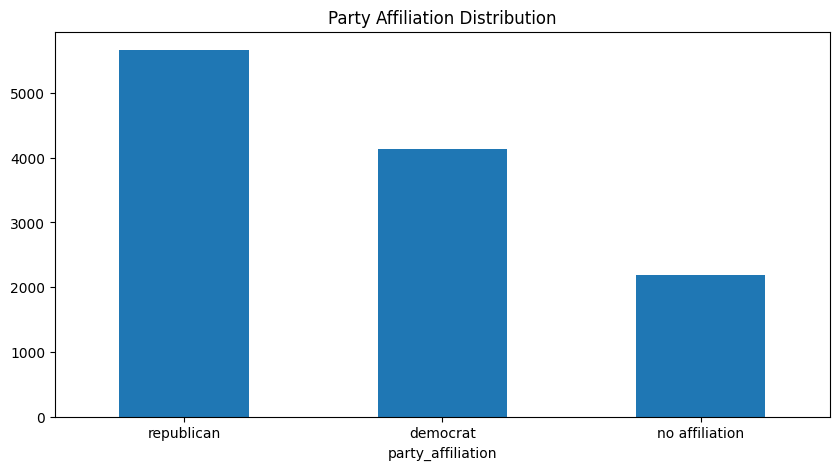

In [13]:
# There is a big difference between the top 3 and the rest. Dropping all columns and keeping only the top 3
# Replacing none with no affiliation
df['party_affiliation'].unique()
df.drop(df[df['party_affiliation'].isin(['democrat','republican','none'])==False].index, inplace=True)
df['party_affiliation'].replace('none','no affiliation', inplace=True)
df['party_affiliation'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Party Affiliation Distribution')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'half-true'),
  Text(1, 0, 'false'),
  Text(2, 0, 'mostly-true'),
  Text(3, 0, 'barely-true'),
  Text(4, 0, 'true'),
  Text(5, 0, 'pants-fire')])

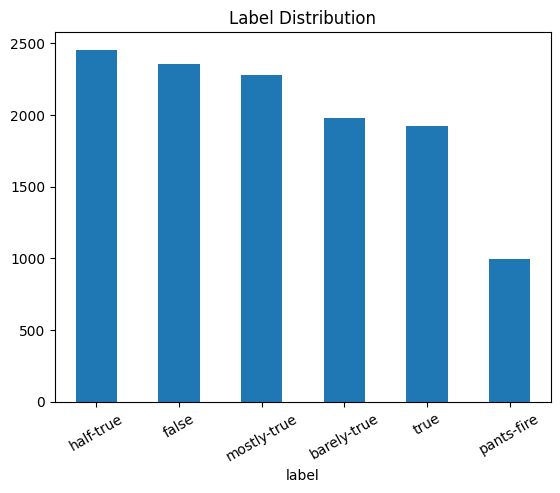

In [14]:
# Distribution of labels
df['label'].value_counts().plot(kind='bar')
plt.title('Label Distribution')
plt.xticks(rotation=30)

Text(0, 0.5, 'Count')

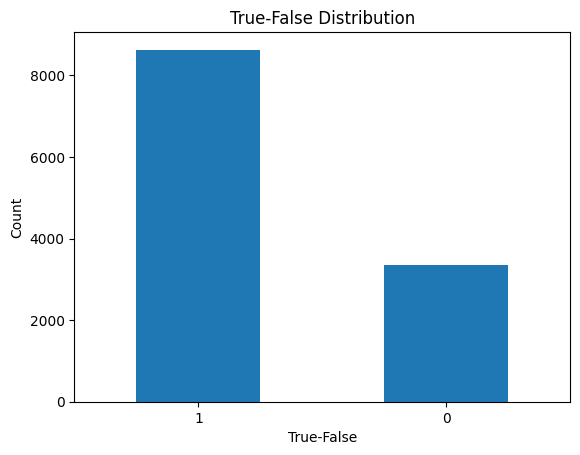

In [15]:
df['ft'].value_counts().plot(kind='bar')
plt.title('True-False Distribution')
plt.xticks(rotation=0, ha='center')
plt.xlabel('True-False')
plt.ylabel('Count')

In [16]:
# Checking length of statements
df['statement'].str.len().describe()

count    11983.000000
mean       107.037553
std         64.471012
min         11.000000
25%         73.000000
50%         98.000000
75%        133.000000
max       3192.000000
Name: statement, dtype: float64

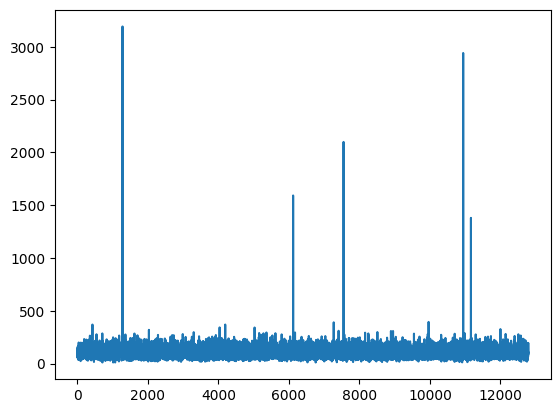

In [17]:
statement_length = df['statement'].apply(len)
statement_length.plot()
plt.show()

In [18]:
statement_length.describe()


count    11983.000000
mean       107.037553
std         64.471012
min         11.000000
25%         73.000000
50%         98.000000
75%        133.000000
max       3192.000000
Name: statement, dtype: float64

In [19]:
# Clearing outliers 
Q1 = statement_length.quantile(0.25)
Q3 = statement_length.quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df = df[statement_length < upper_bound]
statement_length = statement_length[statement_length < upper_bound]

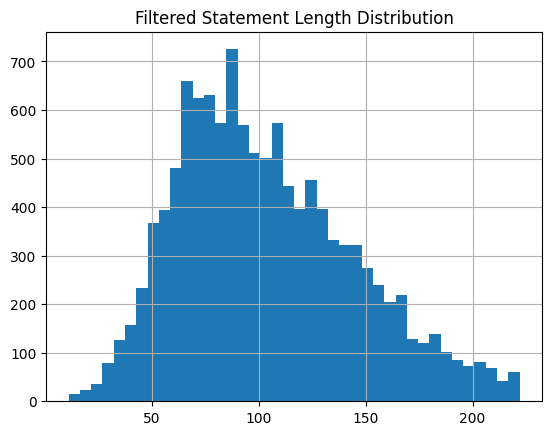

In [20]:
statement_length.hist(bins=40)
plt.title("Filtered Statement Length Distribution")
plt.show()

In [21]:
df['speaker'].value_counts()

speaker
barack-obama       606
donald-trump       339
hillary-clinton    289
mitt-romney        211
john-mccain        187
                  ... 
burger-king          1
paul-babeu           1
kal-penn             1
fred-smith           1
sal-esquivel         1
Name: count, Length: 2855, dtype: int64

Data preprocessing

In [22]:
# tokenize, tokenize, lowercase, remove stop words
stop_words = set(stopwords.words('english'))
custom_punctuations = set(string.punctuation) | {"``", "''", "“", "”", "‘", "’", "`", "–", "—", "...", "…"}

df2=df.copy()
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercase
    tokens = [token.lower() for token in tokens]
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens=[token for token in tokens if token not in custom_punctuations]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into a single string
    return ' '.join(tokens)

df2['processed_text'] = df2['statement'].apply(preprocess_text)
df2.head()

,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,ft,m_label,processed_text
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,0,2,says annies list political group supports thir...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,1,4,decline coal start started natural gas took st...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,1,5,hillary clinton agrees john mccain voting give...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,Unknown,Unknown,no affiliation,7,19,3,5,44,a news release,0,2,health care reform legislation likely mandate ...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,Unknown,Florida,democrat,15,9,20,19,2,an interview on CNN,1,4,economic turnaround started end term


In [23]:
df2[['statement', 'processed_text']].head()


,statement,processed_text
0,Says the Annies List political group supports ...,says annies list political group supports thir...
1,When did the decline of coal start? It started...,decline coal start started natural gas took st...
2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agrees john mccain voting give...
3,Health care reform legislation is likely to ma...,health care reform legislation likely mandate ...
4,The economic turnaround started at the end of ...,economic turnaround started end term


In [24]:
all_words = ' '.join(df2['processed_text']).split()


word_counts = Counter(all_words)

top20=word_counts.most_common(30)
table= PrettyTable(['Word','Count'])
for word,count in top20:
    table.add_row([word,count])
print(table)

+------------+-------+
|    Word    | Count |
+------------+-------+
|    says    |  2759 |
|  percent   |  1316 |
|   state    |  905  |
|   obama    |  878  |
|    tax     |  750  |
|   health   |  720  |
|   years    |  698  |
| president  |  684  |
|   people   |  652  |
|    year    |  617  |
|    care    |  612  |
|   states   |  606  |
|   would    |  603  |
|  million   |  576  |
|    jobs    |  575  |
|    new     |  533  |
|    one     |  515  |
|    bill    |  470  |
|   texas    |  455  |
|    u.s.    |  439  |
|    said    |  437  |
|  federal   |  433  |
|  billion   |  430  |
|   barack   |  427  |
|   every    |  421  |
|   voted    |  418  |
|   taxes    |  406  |
|   since    |  404  |
|   budget   |  392  |
| government |  375  |
+------------+-------+


In [25]:
df2.columns

Index(['label', 'statement', 'subject', 'speaker', 'job_title', 'state_info',
       'party_affiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'ft', 'm_label', 'processed_text'],
      dtype='object')

*Bayes Classification: Multi - Binary*

In [26]:
# Bayes Multi Classifier
# vectorization with scikit-learn
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df2['processed_text'])
y = df2['m_label']-1

#Data slpit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
nb = ComplementNB()

# Define parameters
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Grid Search
grid_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='f1_macro', n_jobs=-1)

grid_nb.fit(X_train, y_train)

print("Best Parameters for ComplementNB:", grid_nb.best_params_)

# Evaluate on test set
y_pred_nb = grid_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb))

Best Parameters for ComplementNB: {'alpha': 1.0}
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       202
           1       0.27      0.25      0.26       469
           2       0.24      0.24      0.24       378
           3       0.24      0.25      0.25       473
           4       0.25      0.30      0.27       441
           5       0.25      0.21      0.23       394

    accuracy                           0.25      2357
   macro avg       0.25      0.25      0.25      2357
weighted avg       0.25      0.25      0.25      2357



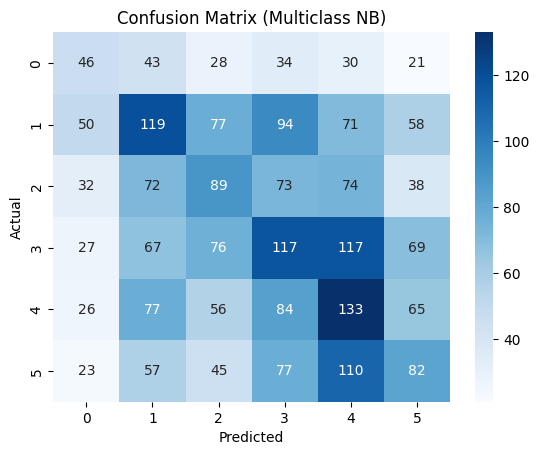

In [28]:
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multiclass NB)")
plt.show()

In [29]:
# Bayers Binary Classifer
X2 = vectorizer.fit_transform(df2['processed_text'])
y2 = df2['ft']

#Data slpit
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [30]:
# Define parameters
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Grid Search
grid_nb2 = GridSearchCV(nb, param_grid_nb, cv=5, scoring='f1_macro', n_jobs=-1)

grid_nb2.fit(X_train2, y_train2)

print("Best Parameters for ComplementNB:", grid_nb2.best_params_)

# Evaluate on test set
y_pred_nb = grid_nb2.predict(X_test)
print(classification_report(y_test2, y_pred_nb))

Best Parameters for ComplementNB: {'alpha': 0.5}
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       671
           1       0.77      0.76      0.77      1686

    accuracy                           0.67      2357
   macro avg       0.60      0.60      0.60      2357
weighted avg       0.67      0.67      0.67      2357



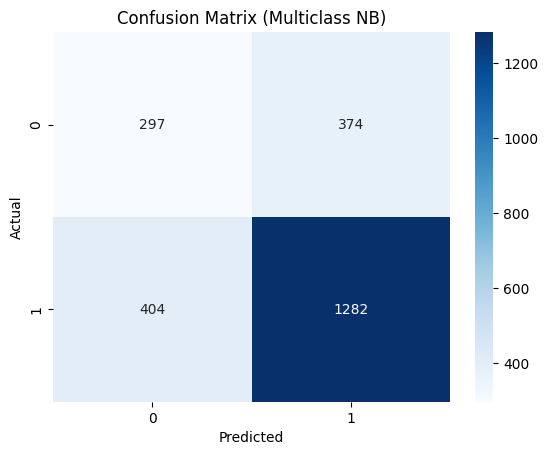

In [31]:
cm2 = confusion_matrix(y_test2, y_pred_nb)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multiclass NB)")
plt.show()

*Logistic Regression*

In [32]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid.fit(X_train2, y_train2)

print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)

# Evaluate on test set
best_lr = grid.best_estimator_
y_pred_lr = best_lr.predict(X_test2)
print(classification_report(y_test2, y_pred_lr))

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7224695719682372
              precision    recall  f1-score   support

           0       0.58      0.07      0.12       671
           1       0.73      0.98      0.83      1686

    accuracy                           0.72      2357
   macro avg       0.65      0.52      0.48      2357
weighted avg       0.68      0.72      0.63      2357



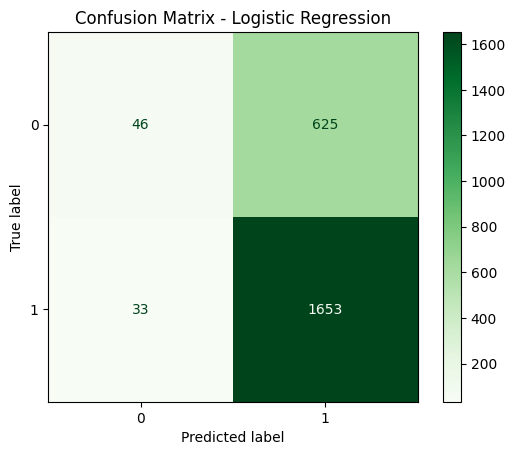

In [33]:
cm_lr = confusion_matrix(y_test2, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=best_lr.classes_)
disp_lr.plot(cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
# LAZY CLASSIFIER
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
liar_df = df2.copy()

# Step 1: Prepare inputs (assuming liar_df already exists with 'processed_text' and 'ft')
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(liar_df['processed_text'])

# Convert to dense DataFrame
X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Step 2: Target
y = liar_df['ft']

# Step 3: Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 4: LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Step 5: View Results
print(models)


  0%|          | 0/32 [00:00<?, ?it/s]